# Assignment 2

The purpose of this assignment is to test your understanding of Classification.  You will use the Titanic dataset and your goal is to predict whether a passenger Survives based on the passenger's features.


# Instructions

## General

1. Use the same train  dataset as was used in the lecture.  Instructions below for where to find them.

2. As usual: your grade depends on **both** the correct answer and properly presenting your process (as in the "Recipe" taught in class, and the Geron book Appendix B)

3. You will classify whether a passenger Survives or not using Logistic Regression.

4. You may use the code presented in class to **start** your assignment but I expect you to significantly enhance it.  For example: you may use my code to get you started with plotting but it is up to you to decide whether this alone suffices.

5. Use 5-fold cross validation for all models.  Report the average as your result.


## Specific goals to address

1. Use a baseline model against which you will compare your models.
    - Discuss your choice.  Is this the best baseline model to use ?
    - Create a variable SCORE_BASELINE that contains a Python scalar value: the accuracy for your baseline model.
2. You will conduct several experiments 
    - present a Confusion Matrix for each experiment and discuss
    - you will create several variables per experiment that will be used for grading.
        - The variables for experiment 1 will have suffix "_1". For experiment 2, they will have suffix "_2", etc.
3. Experiment 1
    - You will *extend* the results presented in the lecture
        - use the same features
        - use the same way of dealing with missing features
        - be sure to treat categorical features correctly
     
    - Create a variable SCORE_1 that contains a Python scalar value: the accuracy for your experiment.
    - Create a variable MISCLASSIFIED_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the identity of passengers that were mis-classified as Surviving.
        - the "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set,
        - The first row is considered row 0
    - Create a variable MISCLASSIFIED_NOT_SURVIVE_1 that contains a Python list of *at least 10* passengers
        - the list should contain the "identity" of passengers that were mis-classified as Not Surviving.
        - The "identity" of a passenger should be given as the  *row number* within the unshuffled **train** data set, as above
4. Experiment 2
    - Turn Age from a continous variable to one that is assigned to buckets.
        - You will decide the range for each bucket.  Discuss your choice
        - Treat the buckets as categorical features
    - Compare your prediction to the previous experiment and discuss
    - Create variables SCORE_2, MISCLASSIFIED_SURVIVE_2, MISCLASSIFIED_NOT_SURVIVE_2 analagous to the variables in Experiment 1
        
The correctness part of your grade will depend on the values you assign to these variables.    

# Extra credit

Create your own Logistic Regression model for the Titanic dataset given !
- Feel free to change **anything**, e.g., features or ways to treat missing values
- We will create a hidden test dataset
- Students whose model accuracy (evaluated on the hidden test dataset) are in the Top 33% of the class get extra credit !


# Getting the data 
You may obtain the train and test datasets from the repository using code from the following cell.

**NOTE** You may need to change the NOTEBOOK_ROOT variable to point to the directory into which you've cloned the repository.  On my machine, it is `~/Notebooks/NYU`.

In [1]:
import pandas as pd
import os

NOTEBOOK_ROOT = "~/Notebooks/NYU"
# NOTEBOOK_ROOT = "~/Desktop/7773 Machine Learning/ML_Spring_2019"
TITANIC_PATH = os.path.join( NOTEBOOK_ROOT, "external/jack-dies", "data")

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

# Baseline Model

<span style="color:blue; font-size:1.2em" >
The baseline model I use is a coin flip model. The head suggests that Survive, and the tail suggests Not-Survive. We do not use any information in the data set, and it is basically a guess about whether a specific passenger would survive or not. In the following Experiment 1 and 2, we will compare the accuracy between the coin flip game and the fine-tuned Logistic Regression Model.
</span>

In [4]:
# define the coin flip model
def TitanicCoinFlip(X):
    """
    Parameter: X: passenger data object
    Return: y_predict: a list of predicted values
    """
    y_predict = []
    random.seed(42)
    for i in range(len(X)):
        # random number generated > 0.5 represents Survive
        if random.random() > 0.5:
            y_predict.append(1)
        else:
        # random number generated < 0.5 represents Survive
            y_predict.append(0)
    
    return y_predict

In [5]:
# the predicted values
titanic_y_predict = np.array(TitanicCoinFlip(train_data))
# the true values
titanic_train_labels = train_data["Survived"]

# the Baseline Score of the Coin Flip Model
SCORE_BASELINE = accuracy_score(titanic_train_labels.values, titanic_y_predict)
print("Score Baseline: ", SCORE_BASELINE)

Score Baseline:  0.5050505050505051


<span style="color:blue; font-size:1.2em" >
The score baseline shows that there is about 50% chance that the model will make a correct prediction on whether a specific passenger would survive or not.
</span>

# Experiement 1

In [6]:
# Drop the data not possibly used in the training.
# PassengerId, Name, Ticket are not relevant.
# Cabin has too much missed values. It is unable to use it.

# X_train
titanic_train = train_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
# y_train
titanic_train_labels = train_data["Survived"]

In [7]:
# seperate the data into two part: numerical and categorical

# numerical data of training set
titanic_train_num = titanic_train[["Age", "SibSp", "Parch", "Fare"]]
# categorical data of training set
titanic_train_cat = titanic_train[["Pclass", "Sex", "Embarked"]]

In [8]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

In [9]:
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(sparse=False))
])

In [10]:
num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [11]:
# training set transformed by all the pipeline(imputer, encoder, standard scaler)
titanic_train_prepared = full_pipeline.fit_transform(titanic_train)

In [12]:
logistic_clf = LogisticRegression(solver="liblinear")
logistic_clf.fit(titanic_train_prepared, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

<span style="color:blue; font-size:1.2em" >
The score of accuracy of Experiment 1 shows below.
</span>

In [13]:
SCORE_1 = cross_val_score(logistic_clf, titanic_train_prepared, titanic_train_labels, cv=5, scoring="accuracy")
SCORE_1 =  SCORE_1.mean()
print("Score of Experiment 1: {s}".format(s=SCORE_1))

Score of Experiment 1: 0.7924214488541156


In [14]:
titanic_train_predict = logistic_clf.predict(titanic_train_prepared)
titanic_train_confusion_matrix = confusion_matrix(titanic_train_labels, titanic_train_predict)

<span style="color:blue; font-size:1.2em" >
The Confusion Matrix of Experiment 1 shows below.
</span>

In [15]:
CONFUSION_MATRIX_1 = pd.DataFrame(titanic_train_confusion_matrix, 
                                  columns=["Predicted Negative", "Predicted Positive"],
                                  index=["Actual Negative", "Actual Positive"])
print("Confusion Matrix of Experiment 1: \n")
print(CONFUSION_MATRIX_1)

Confusion Matrix of Experiment 1: 

                 Predicted Negative  Predicted Positive
Actual Negative                 478                  71
Actual Positive                 102                 240


In [16]:
titanic_subtract = titanic_train_predict - titanic_train_labels
# 1 suggests that (survive) - (not survive) = misclassified survive
# -1 suggests that (not survive) - (survive) = misclassified not survive

MISCLASSIFIED_SURVIVE_1 = list(titanic_subtract[titanic_subtract == 1].index)
MISCLASSIFIED_NOT_SURVIVE_1 = list(titanic_subtract[titanic_subtract == -1].index)

<span style="color:blue; font-size:1.2em" >
Lastly, the misclassification outcome of Experiment 1 shows below.
</span>

In [17]:
print("Misclassified Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_SURVIVE_1)))
print(MISCLASSIFIED_SURVIVE_1, "\n")
print("Misclassified Not Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_NOT_SURVIVE_1)))
print(MISCLASSIFIED_NOT_SURVIVE_1, "\n")

Misclassified Survive Passengers: Total 71

[14, 18, 24, 34, 38, 41, 49, 64, 100, 102, 111, 113, 114, 118, 139, 140, 147, 177, 199, 205, 235, 240, 246, 264, 293, 295, 297, 312, 357, 362, 373, 374, 377, 396, 402, 404, 415, 419, 423, 452, 474, 498, 501, 502, 503, 505, 527, 534, 557, 564, 567, 578, 583, 593, 617, 634, 642, 654, 657, 680, 702, 729, 766, 767, 772, 793, 807, 816, 852, 854, 882] 

Misclassified Not Survive Passengers: Total 102

[17, 21, 23, 25, 36, 55, 65, 68, 74, 78, 81, 85, 107, 125, 127, 146, 165, 183, 187, 193, 204, 207, 209, 220, 224, 226, 233, 248, 261, 267, 271, 279, 283, 286, 288, 298, 301, 328, 338, 340, 348, 390, 391, 400, 407, 414, 429, 430, 444, 447, 449, 453, 455, 460, 483, 489, 507, 509, 510, 512, 543, 547, 549, 553, 559, 569, 570, 572, 579, 587, 599, 607, 621, 622, 630, 643, 645, 647, 660, 664, 673, 690, 692, 701, 707, 709, 712, 724, 740, 744, 751, 755, 762, 788, 803, 804, 821, 828, 831, 838, 857, 869] 



# Experiment 2

<span style="color:blue; font-size:1.2em" >
I plot the histograms of Age of the Survived and the Not-Survived below.
The difference between the two histograms shows that the children 10 years old or younger have a higher probability to survive and the passengers older than 60 have a higher probility to die. Thus, I decide to make that 0-10 is the first bucket, 10-40 is the second bucket, 40-60 is the third bucket, and above 60 is the fourth bucket.
</span>

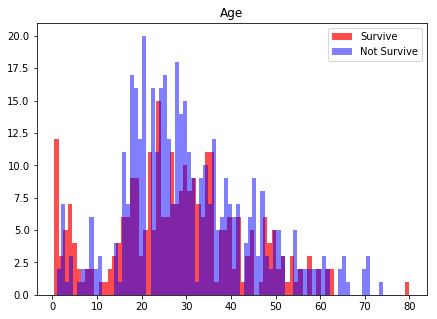

In [18]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax = train_data[train_data["Survived"] == 1]["Age"].hist(bins=80, color="red", alpha=0.7, label="Survive")
ax = train_data[train_data["Survived"] == 0]["Age"].hist(bins=80, color="blue", alpha=0.5, label="Not Survive")
ax.set_title("Age")
plt.legend()
plt.grid()

In [19]:
def AgeCat(x):
    if x < 10:
        return 0
    if 10 <= x < 40:
        return 1
    if 40 <= x < 60:
        return 2
    if x >= 60:
        return 3

train_data["AgeBucket"] = train_data["Age"].apply(AgeCat)

In [20]:
# Drop the data not possibly used in the training.
# PassengerId, Name, Ticket are not relevant.
# Cabin has too much missed values. It is unable to use it.
# Age is replaced for AgeBucket. Drop Age.

# X_train
titanic_train = train_data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Age"], axis=1)
# y_train
titanic_train_labels = train_data["Survived"]

In [21]:
# seperate the data into two part: numerical and categorical

# numerical data of training set
titanic_train_num = titanic_train[["SibSp", "Parch", "Fare"]]
# categorical data of training set
# AgeBucket is categorical
titanic_train_cat = titanic_train[["Pclass", "Sex", "Embarked", "AgeBucket"]]

In [22]:
num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [23]:
# training set transformed by all the pipeline(imputer, encoder, standard scaler)
titanic_train_prepared = full_pipeline.fit_transform(titanic_train)

In [24]:
logistic_clf = LogisticRegression(solver="liblinear")
logistic_clf.fit(titanic_train_prepared, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [25]:
SCORE_2 = cross_val_score(logistic_clf, titanic_train_prepared, titanic_train_labels, cv=5, scoring="accuracy")
SCORE_2 =  SCORE_2.mean()
print("Score of Experiment 2: {s}".format(s=SCORE_2))

Score of Experiment 2: 0.8047307828570031


<span style="color:blue; font-size:1.2em" >
The score of Experiment 2 shows a higher accuracy than Experiment 1. Thus, the age buckets we make did help boost the accuracy of prediction. An effective classification and simplification of some features would help the machine learning algorithm generate a more precise outcome.
</span>

In [26]:
titanic_train_predict = logistic_clf.predict(titanic_train_prepared)

In [27]:
titanic_train_confusion_matrix = confusion_matrix(titanic_train_labels, titanic_train_predict)

In [28]:
CONFUSION_MATRIX_2 = pd.DataFrame(titanic_train_confusion_matrix, 
                                  columns=["Predicted Negative", "Predicted Positive"],
                                  index=["Actual Negative", "Actual Positive"])
print("Confusion Matrix of Experiment 2: \n")
print(CONFUSION_MATRIX_2)

Confusion Matrix of Experiment 2: 

                 Predicted Negative  Predicted Positive
Actual Negative                 479                  70
Actual Positive                  96                 246


In [29]:
titanic_subtract = titanic_train_predict - titanic_train_labels
# 1 suggests that (survive) - (not survive) = misclassified survive
# -1 suggests that (not survive) - (survive) = misclassified not survive

MISCLASSIFIED_SURVIVE_2 = list(titanic_subtract[titanic_subtract == 1].index)
MISCLASSIFIED_NOT_SURVIVE_2 = list(titanic_subtract[titanic_subtract == -1].index)

<span style="color:blue; font-size:1.2em" >
Lastly, the misclassification outcome of Experiment 2 shows below.
</span>

In [30]:
print("Misclassified Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_SURVIVE_2)))
print(MISCLASSIFIED_SURVIVE_2, "\n")
print("Misclassified Not Survive Passengers: Total {p}\n".format(p=len(MISCLASSIFIED_NOT_SURVIVE_2)))
print(MISCLASSIFIED_NOT_SURVIVE_2, "\n")

Misclassified Survive Passengers: Total 70

[14, 18, 24, 41, 49, 64, 100, 111, 113, 114, 118, 119, 139, 140, 147, 177, 199, 205, 235, 240, 246, 264, 276, 293, 295, 297, 312, 357, 362, 373, 374, 377, 396, 402, 404, 415, 419, 452, 474, 498, 501, 502, 503, 505, 527, 534, 541, 557, 564, 578, 583, 593, 617, 634, 642, 654, 657, 680, 702, 729, 766, 767, 772, 793, 807, 813, 816, 852, 854, 882] 

Misclassified Not Survive Passengers: Total 96

[17, 21, 23, 25, 36, 55, 65, 68, 74, 81, 85, 107, 125, 127, 146, 165, 183, 187, 204, 207, 209, 220, 224, 226, 248, 261, 267, 271, 279, 283, 286, 288, 298, 301, 328, 338, 348, 370, 390, 391, 400, 414, 429, 430, 444, 447, 449, 453, 455, 460, 483, 484, 489, 507, 509, 510, 512, 543, 547, 553, 569, 570, 572, 579, 587, 599, 607, 621, 622, 630, 643, 645, 647, 660, 664, 673, 690, 692, 701, 707, 709, 712, 724, 740, 744, 751, 762, 788, 802, 803, 804, 821, 828, 838, 857, 869] 



# Extra Credit

<span style="color:blue; font-size:1.2em" >
Firstly, we try to do feature engineering, by creating some new features to help boost the accuracy.
</span>

In [31]:
# define a function to create some new features to help boost the accuracy
def CreateNewFeature(Data):
    # New Feature: Age Categories
    df = Data
    def AgeCat(x):
        if x < 10:
            return 0
        if 10 <= x < 40:
            return 1
        if 40 <= x < 60:
            return 2
        if x >= 60:
            return 3
    df["AgeBucket"] = df["Age"].apply(AgeCat)
    
    # New Feature: Fare Categories
    def FareCat(x):
        if x < 15:
            return 0
        if 15 <= x <35:
            return 1
        if 35 <= x <90:
            return 2
        else:
            return 3    
    df["FareCat"] = df["Fare"].apply(FareCat)
    
    # New Feature: Passenger Class & Sex
    df["PclassSex"] = df["Pclass"].apply(str) + df["Sex"]
    
    # New Feature: Family Size
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    
    # New Feature: Is Alone
    def Alone(x):
        if x == 1:
            return 1
        else:
            return 0
    df["IsAlone"] = df["FamilySize"].apply(Alone)
    
    # New Feature: Name Length
    df["NameLen"] = df["Name"].apply(len)
    
    # New Feature: Name Prefix
    df["NamePre"] = df["Name"].apply(lambda x: x.split()[1])
    # Simplify the Name Prefix Categories
    def NamePreCat(x):
        if x not in ["Mr.", "Miss.", "Mrs.", "Masters."]:
            return "Others"
        else:
            return x
    df["NamePre"] = df["NamePre"].apply(NamePreCat)
    
    return df

In [32]:
new_train_data = CreateNewFeature(train_data)

In [33]:
# X_train
titanic_train = new_train_data[["SibSp", "Parch", "Embarked", "Pclass", "Sex",
                           "PclassSex", "FamilySize", "FareCat", "AgeBucket", 
                           "IsAlone", "NameLen", "NamePre"]]
# y_train
titanic_train_labels = new_train_data["Survived"]

In [34]:
# seperate the data into two part: numerical and categorical

# numerical data of training set
titanic_train_num = titanic_train[["SibSp", "Parch", "FamilySize", "NameLen"]]
# categorical data of training set
# AgeBucket is categorical
titanic_train_cat = titanic_train[["Embarked", "PclassSex", "FareCat", "AgeBucket", "IsAlone"]]

In [35]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(sparse=False))
])

num_attribs = list(titanic_train_num)
cat_attribs = list(titanic_train_cat)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [36]:
# training set transformed by all the pipeline(imputer, encoder, standard scaler)
titanic_train_prepared = full_pipeline.fit_transform(titanic_train)

In [37]:
logistic_clf = LogisticRegression(solver="liblinear")
logistic_clf.fit(titanic_train_prepared, titanic_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

<span style="color:blue; font-size:1.2em" >
Using 5-fold Cross Validation, we calculate the accuracy of the new model below. By doing feature engineering and creating new features, the model does make more accurate prediction.
</span>

In [38]:
SCORE = cross_val_score(logistic_clf, titanic_train_prepared, titanic_train_labels, cv=5, scoring="accuracy")
SCORE =  SCORE.mean()
print("Score: {s}".format(s=SCORE))

Score: 0.8159540419187691


In [39]:
titanic_train_predict = logistic_clf.predict(titanic_train_prepared)

In [40]:
titanic_train_confusion_matrix = confusion_matrix(titanic_train_labels, titanic_train_predict)

<span style="color:blue; font-size:1.2em" >
The Confusion Matrix of this new model shows below.
</span>

In [41]:
CONFUSION_MATRIX = pd.DataFrame(titanic_train_confusion_matrix, 
                                  columns=["Predicted Negative", "Predicted Positive"],
                                  index=["Actual Negative", "Actual Positive"])
print("Confusion Matrix: \n")
print(CONFUSION_MATRIX)

Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 504                  45
Actual Positive                 106                 236


<span style="color:blue; font-size:1.2em" >
Lastly, all the predicted values of the test data show below.
</span>

In [42]:
new_test_data = CreateNewFeature(test_data)

# X_test
titanic_test = new_test_data[["SibSp", "Parch", "Embarked", 
                           "PclassSex", "FamilySize", "FareCat", "AgeBucket", 
                           "IsAlone", "NameLen", "NamePre"]]

titanic_test_prepared = full_pipeline.fit_transform(titanic_test)

test_predict = logistic_clf.predict(titanic_test_prepared)
print(test_predict)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]
